##### Imports

In [1]:
import os, gc
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.io import fits

from scipy.optimize import curve_fit
from scipy.linalg import lstsq
from scipy.ndimage import label, find_objects

In [ ]:
# !pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.1 MB/s eta 0:00:00:00:0100:01


In [2]:
from shapely.geometry import box as ShapelyBox
from shapely.affinity import rotate, translate

In [3]:
from shapely.geometry import Polygon as ShapelyPolygon
from matplotlib.patches import Rectangle, Polygon
from matplotlib.colors import Normalize

In [4]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import RANSACRegressor

In [5]:
from scipy.ndimage import map_coordinates
from scipy.interpolate import interp1d
import numpy as np

In [ ]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_config, veloce_extraction

### Fit Tilt across detector

##### Functions

In [7]:
def general_gaussian(x, A, mu, sigma, beta, baseline):
    return A * np.exp(-np.abs(((x - mu)/(np.sqrt(2)*sigma)))**beta) + baseline

In [8]:
def get_lines(data, traces, MATCH_PIX, Y0):
    selected_lines = []
    line_positions = []
    order_numbers = []

    n = 0
    for trace_x, match_pix, lower, upper, y0 in zip(traces.x, MATCH_PIX, traces.summing_ranges_lower, traces.summing_ranges_upper, Y0):
        n += 1
        for y in match_pix:
            y += y0
            x_min = int(trace_x[int(y)] - lower)
            x_max = int(trace_x[int(y)] + upper)
            y_min = int(y - 7)
            y_max = int(y + 7)
            subregion = data[y_min:y_max, x_min:x_max]
            selected_lines.append(subregion)
            line_positions.append((trace_x[int(y)], y))
            order_numbers.append(n)
    line_positions = np.array(line_positions)
    order_numbers = np.array(order_numbers)

    return selected_lines, line_positions, order_numbers

In [9]:
def clip_line(line_region, plot=False):
    # line_region_mask = line_region > np.min(line_region) + np.std(line_region)
    line_region_mask = line_region > np.median(line_region) + np.std(line_region)
    labeled_array, num_features = label(line_region_mask)
    if num_features == 0:
        print("No features found in the line region. Returning array of NaN.")
        return np.full(line_region.shape, np.nan)
    # elif num_features != 3:
    #     print(f"Expected 3 features, found {num_features}. This may lead to incorrect clipping.")
    if plot:
        plt.figure(figsize=(10, 5))
        plt.imshow(labeled_array, origin='lower', cmap='jet')
        plt.title('Labeled Line Region')
        # plt.colorbar(label='Label Index')
        plt.show()
    objects = find_objects(labeled_array)
    sizes = [np.sum(labeled_array[obj] > 0) for obj in objects]
    line_index = np.argmax(sizes)
    line_slice = objects[line_index][1]
    clipped_line = line_region[(slice(None,None,None), line_slice)]

    if clipped_line.shape[1] < 39:
        print("Too stringent clipping. Returning array of NaN.")
        return np.full(line_region.shape, np.nan)

    return clipped_line

In [10]:
def find_tilt(line_region, plot=False):
    line_region = clip_line(line_region, plot=plot)
    
    centre = []
    for column in range(line_region.shape[1]):
        profile = line_region[:, column]
        pix = np.arange(len(profile))
        pix_min, pix_max = np.min(pix), np.max(pix)
        try:
            popt, _ = curve_fit(general_gaussian, pix, profile, p0=[np.max(profile), pix_max/2, 2, 2, 0])
            # if plot:
            #     print(f"Fitted Gaussian for column {column}: A={popt[0]}, mu={popt[1]}, sigma={popt[2]}, beta={popt[3]}, baseline={popt[4]}")
            if popt[1] < pix_min or popt[1] > pix_max:
                print(f"Fitted mu {popt[1]} out of bounds for column {column}. Setting to NaN.")
                centre.append(np.nan)
            else:
                centre.append(popt[1])
        except:
            centre.append(np.nan)
    centre = np.array(centre)
    centre_x = np.arange(len(centre))
    centre, centre_x = centre[~np.isnan(centre)], centre_x[~np.isnan(centre)]
    if len(centre) < 10:
        print("Not enough valid points to fit a line. Returning NaN.")
        return np.nan, np.nan
    line, cov_matrix  = np.polyfit(np.arange(len(centre)), centre, 1, cov=True)
    uncertainties = np.sqrt(np.diag(cov_matrix))
    
    # if abs(line[0]) > 5:
    #     return np.nan, np.nan
    if plot:
        plt.figure(figsize=(10, 5))
        plt.imshow(line_region, norm='log', origin='lower', aspect='auto', cmap='gray')
        plt.plot(centre_x, centre, 'o', label='fitted centres')
        plt.plot(centre_x, line[0] * centre_x + line[1], 'r-', label='Fitted Line')
        plt.xlabel('cross-dispersion pixel')
        plt.ylabel('dispersion pixel')
        plt.title('Tilt Calculation')
        plt.legend()
        # plt.grid()
        plt.show()
    
    return line[0], uncertainties[0]

##### Load ThAr Obs

In [11]:
run = "CSV_Run"
date = '230826'
# arm = 'blue'
arm = 'green'
# arm = 'red'
# ccd = 'ccd_1'
ccd = 'ccd_2'
# ccd = 'ccd_3'
amplifier_mode = 4
# filename = '26aug20055.fits'
# filename = '26aug20061.fits'
science_targets = ['HD20203-USQ01']

In [12]:
input_dir = f'/home/usqobserver2/VeloceData/{run}/'
output_dir = '/home/usqobserver2/Joachim_veloce/Extracted_data/Slit/'

In [13]:
veloce_paths = veloce_config.VelocePaths(input_dir=input_dir, output_dir=output_dir)

In [14]:
obs_list = veloce_config.load_night_logs(date, science_targets, arm, veloce_paths=veloce_paths)

In [15]:
# data, header = veloce_reduction_tools.get_master_mmap(obs_list, f'ARC-ThAr_{arm}', input_dir, date, arm, amplifier_mode)

In [16]:
master_filename = f'Master/master_ARC-ThAr_{arm}_{date}.fits'
# veloce_reduction_tools.save_image_fits(master_filename, data, header)
with fits.open(master_filename) as hdul:
    data= hdul[0].data
    header = hdul[0].header

In [17]:
# with fits.open(os.path.join(veloce_paths.input_dir, date, ccd, filename)) as hdul:
#     image_data= hdul[0].data
#     header = hdul[0].header

In [18]:
# data = veloce_reduction_tools.remove_overscan_bias(image_data, hdr=header, arm=arm, amplifier_mode=amplifier_mode, overscan_range=32)

In [19]:
traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl'))

In [20]:
# order_nums, coeffs, traces_2 = veloce_reduction_tools.load_prefitted_wavecalib_trace(arm=arm, calib_type='Th')

In [21]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm=arm, wave_path=veloce_paths.wave_dir)

In [22]:
# %matplotlib widget
%matplotlib inline

In [23]:
# data, hdr = veloce_extraction.remove_scattered_light(data, header, traces=traces)

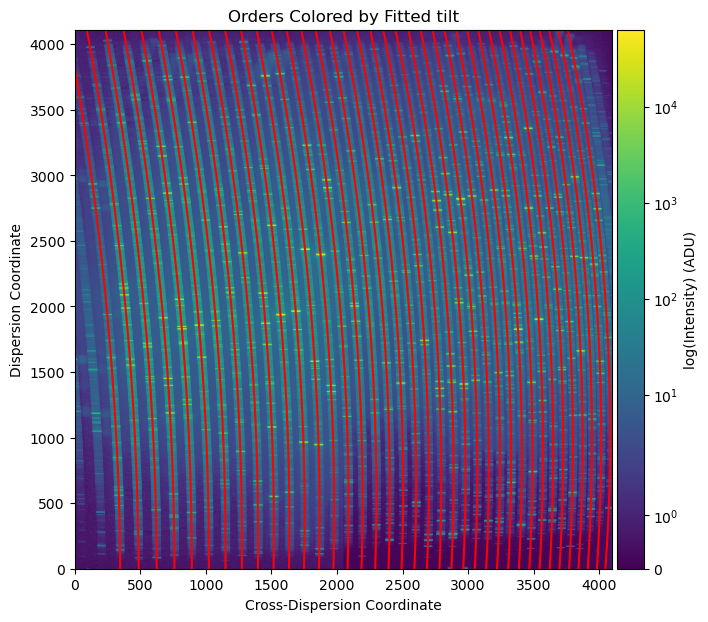

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(data, norm='symlog', origin='lower')
lower_mod, upper_mod = 23, 21
for trace_y, trace_x, lower, upper in traces:
# for trace_y, trace_x in traces_2:
    plt.plot(trace_x,trace_y, c='r')
    # plt.plot(trace_x+upper_mod,trace_y, ls=':', c='r')
    # plt.plot(trace_x-lower_mod,trace_y, ls='--', c='r')
i = 0

# for trace_x, match_pix, lower, upper, y0 in zip(traces.x, MATCH_PIX, traces.summing_ranges_lower, traces.summing_ranges_upper, Y0):
#     # lower, upper = 26, 21
#     for y in match_pix:
#         y += y0
#         i+=1
#         plt.plot([trace_x[int(y)] - lower, trace_x[int(y)] + upper, trace_x[int(y)] + upper, trace_x[int(y)] - lower, trace_x[int(y)] - lower],
#              [y - 5, y - 5, y + 5, y + 5, y - 5], c='r')
#         plt.text(trace_x[int(y)], y, str(i), color='red', fontsize=8, ha='center', va='center')

# Plot the masked proxy data as a colormap
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label='log(Intensity) (ADU)')
ax.set_title('Orders Colored by Fitted tilt')
ax.set_xlabel('Cross-Dispersion Coordinate')
ax.set_ylabel('Dispersion Coordinate')
plt.show()

In [25]:
plt.close()

##### Identify lines

In [26]:
selected_lines, line_positions, order_numbers = get_lines(data, traces, MATCH_PIX, Y0)

In [27]:
len(order_numbers)

869

In [28]:
%matplotlib inline

In [29]:
# n = 160
n = int(np.random.random()*(len(order_numbers)-1))

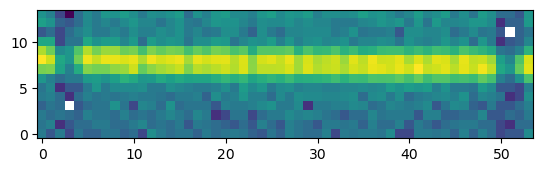

In [30]:
# plt.imshow(data[972:988, 1865:1914], norm='log')
plt.imshow(selected_lines[n], norm='log', origin='lower')

In [31]:
slit_profile = np.sum(selected_lines[n], axis=1)

In [32]:
aligned_slit_profile = None #TODO

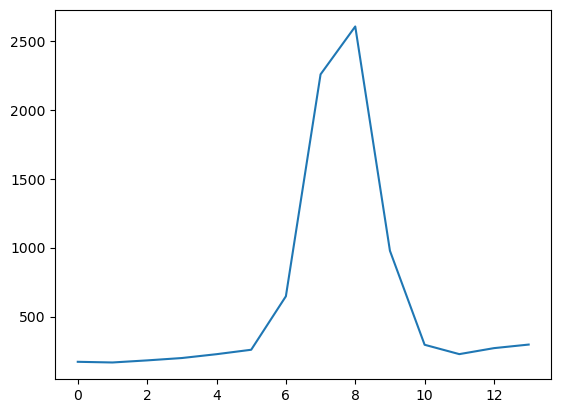

In [33]:
plt.plot(slit_profile)

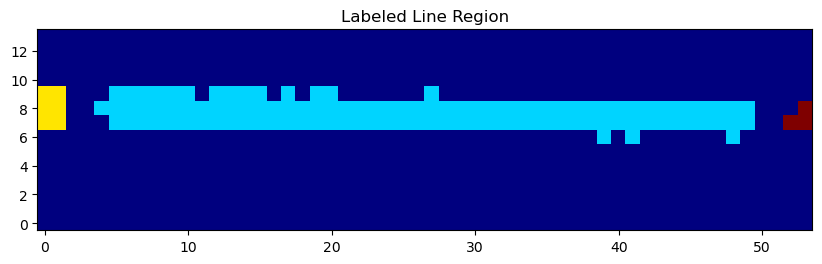

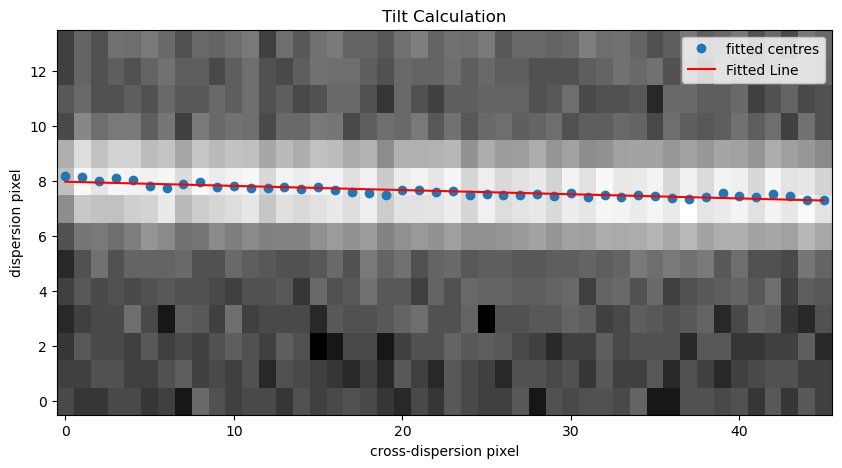

(-0.015182744401898539, 0.00106070155678845)

In [34]:

find_tilt(selected_lines[n], plot=True)

In [35]:
# poly = np.polyfit(np.arange(len(centre)), centre, 2)
# line = np.polyfit(np.arange(len(centre)), centre, 1)

##### Fit and investigate tilt

In [36]:
tilt = [find_tilt(line_region) for line_region in selected_lines]

Too stringent clipping. Returning array of NaN.
Not enough valid points to fit a line. Returning NaN.
Too stringent clipping. Returning array of NaN.
Not enough valid points to fit a line. Returning NaN.
Too stringent clipping. Returning array of NaN.
Not enough valid points to fit a line. Returning NaN.


/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Not enough valid points to fit a line. Returning NaN.
Too stringent clipping. Returning array of NaN.
Not enough valid points to fit a line. Returning NaN.
Too stringent clipping. Returning array of NaN.
Not enough valid points to fit a line. Returning NaN.
Too stringent clipping. Returning array of NaN.
Not enough valid points to fit a line. Returning NaN.
Not enough valid points to fit a line. Returning NaN.
Fitted mu -8.594203565685818 out of bounds for column 0. Setting to NaN.
Fitted mu -17.912940020773206 out of bounds for column 2. Setting to NaN.
Fitted mu -54.11152968155387 out of bounds for column 4. Setting to NaN.
Fitted mu -17.83622004101252 out of bounds for column 8. Setting to NaN.
Fitted mu 4380.337162580605 out of bounds for column 11. Setting to NaN.
Fitted mu -43.69644596300976 out of bounds for column 16. Setting to NaN.
Fitted mu 666.3016456800506 out of bounds for column 18. Setting to NaN.
Fitted mu -361.5324300218283 out of bounds for column 19. Setting to NaN.

In [37]:
tilt = np.array(tilt)
int(len(tilt[np.isfinite(tilt)])/2), len(tilt)

(807, 869)

In [38]:
# significant_tilt = 0
# count = 0
# # for i, order in enumerate(tilt):
#     # for j, element in enumerate(order):
# for element in tilt:
#     count += 1
#     if abs(element[0]) > 1*element[1]:
#         significant_tilt += 1
#             # print(f"Condition met at order {i}, element {j}: {element}")
# print(f"Significant tilt found in {significant_tilt} out of {count} elements.")

In [39]:
# %matplotlib widget

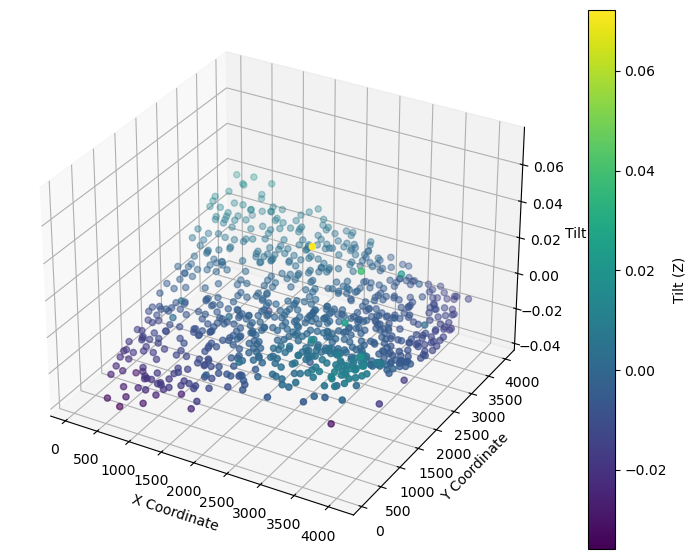

In [40]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Flatten line_positions and tilt for plotting
# x_coords = np.array([pos[0] for order in line_positions for pos in order])
x_coords = np.array([pos[0] for pos in line_positions])
# x_coords = order_numbers
# y_coords = np.array([pos[1] for order in line_positions for pos in order])
y_coords = np.array([pos[1] for pos in line_positions])
# z_coords = np.array([element[0] for order in tilt for element in order])
z_coords = np.array([element[0] for element in tilt])
z_coords = np.array(z_coords)
z_mask = abs(z_coords) < 1
z_coords = z_coords[z_mask]
x_coords = x_coords[z_mask]
y_coords = y_coords[z_mask] 

# Plot the 3D scatter plot
scatter = ax.scatter(x_coords, y_coords, z_coords, c=z_coords, cmap='viridis', marker='o')

# Add labels and color bar
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Tilt')
fig.colorbar(scatter, ax=ax, label='Tilt (Z)')

plt.show()

In [41]:
plt.close()

In [42]:
# tilt_values = np.array([element[0] for order in tilt for element in order if abs(element[0]) < 1])
tilt_values = np.array([element[0] for element in tilt])

median_tilt = np.nanmedian(tilt_values)

# Calculate the mean and standard deviation of the tilt values
mean_tilt = np.nanmean(tilt_values)
std_tilt = np.nanstd(tilt_values)

# Discard outliers greater than 3 sigma
filtered_tilt_values = [value for value in tilt_values if abs(value - mean_tilt) <= 3 * std_tilt]

# Calculate the new median
filtered_median_tilt = np.nanmedian(filtered_tilt_values)

# Compare the results
print(f"Original Median: {median_tilt}")
print(f"Filtered Median: {filtered_median_tilt}")

Original Median: -0.00201923969712022
Filtered Median: -0.0020120064020740878


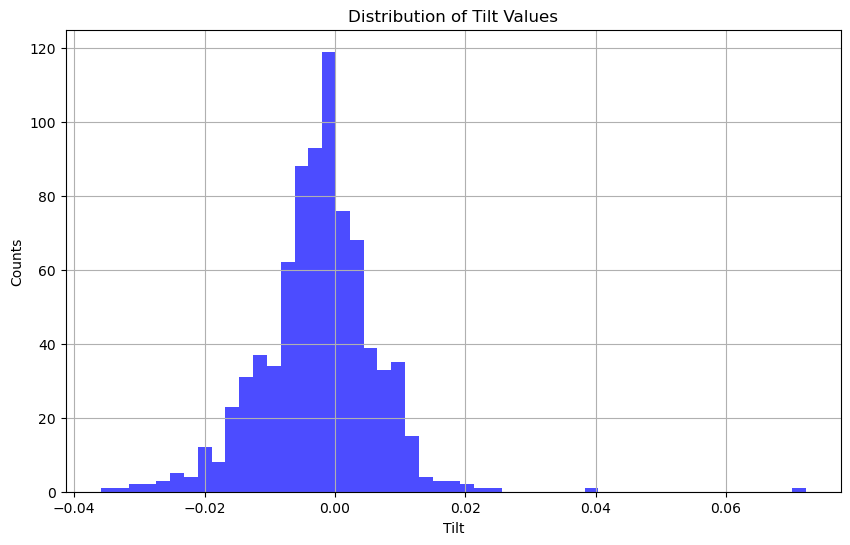

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(tilt_values, bins=51, color='blue', alpha=0.7, align='mid')
plt.xlabel('Tilt')
plt.ylabel('Counts')
plt.title('Distribution of Tilt Values')
plt.grid(True)
plt.show()

In [44]:
# len(tilt_values[np.isfinite(tilt_values)]), np.nanstd(tilt_values), np.nanmean(tilt_values), np.nanmedian(tilt_values), np.nanmin(tilt_values), np.nanmax(tilt_values)

In [45]:
# len(tilt_values[np.isfinite(tilt_values) & (abs(tilt_values) <= 0.027)])/len(tilt_values[np.isfinite(tilt_values)])

##### Polynomial per order solution

In [70]:
# Dictionary to store the fitted polynomials for each order
def fit_poly_per_order(tilt_values, line_positions, order_numbers):
    order_fits = {}
    order_masks = {}
    z_mask = abs(tilt_values) < 1
    # Iterate over unique order numbers
    unique_orders = np.unique(order_numbers)
    for order in unique_orders:
        # Select points corresponding to the current order
        mask = (order_numbers == order) & z_mask
        y_coords_order = line_positions[mask, 1]  # Use y-coordinates (dispersion)
        z_values_order = tilt_values[mask]        # Corresponding tilt values

        # Ensure there are enough points to fit
        if len(y_coords_order) > 2:
            # Iterative outlier removal
            max_iterations = 10
            sigma_threshold = 2.5
            prev_outliers_number = 0
            inlier_mask = np.ones_like(y_coords_order, dtype=bool)  # Start with all points as inliers
            for it in range(max_iterations):
                # Fit a polynomial (degree 1)
                poly_coeffs = np.polyfit(y_coords_order[inlier_mask], z_values_order[inlier_mask], deg=2)
                poly_fit = np.polyval(poly_coeffs, y_coords_order)

                # Calculate residuals
                residuals = z_values_order - poly_fit
                std_dev = np.std(residuals[inlier_mask])

                # Identify inliers
                inlier_mask = np.abs(residuals) < sigma_threshold * std_dev
                if sum(~inlier_mask) == prev_outliers_number:
                    break  # Stop if no outliers are removed
                prev_outliers_number = sum(~inlier_mask)

                # Update data with inliers only
                y_coords_order = y_coords_order
                z_values_order = z_values_order

            print(f"Fitted polynomial in {it+1} iterations, with {prev_outliers_number} outliers removed.")

            order_fits[order] = poly_coeffs
            order_masks[order] = inlier_mask

        else:
            print(f"Not enough points to fit for order {order}")
    return order_fits, order_masks


In [71]:
order_fits, order_masks = fit_poly_per_order(tilt_values, line_positions, order_numbers)

Fitted polynomial in 1 iterations, with 0 outliers removed.
Fitted polynomial in 3 iterations, with 2 outliers removed.
Fitted polynomial in 4 iterations, with 3 outliers removed.
Fitted polynomial in 3 iterations, with 3 outliers removed.
Fitted polynomial in 2 iterations, with 1 outliers removed.
Fitted polynomial in 2 iterations, with 1 outliers removed.
Fitted polynomial in 2 iterations, with 1 outliers removed.
Fitted polynomial in 1 iterations, with 0 outliers removed.
Fitted polynomial in 3 iterations, with 2 outliers removed.
Fitted polynomial in 2 iterations, with 1 outliers removed.
Fitted polynomial in 4 iterations, with 3 outliers removed.
Fitted polynomial in 2 iterations, with 1 outliers removed.
Fitted polynomial in 1 iterations, with 0 outliers removed.
Fitted polynomial in 2 iterations, with 2 outliers removed.
Fitted polynomial in 1 iterations, with 0 outliers removed.
Fitted polynomial in 3 iterations, with 2 outliers removed.
Fitted polynomial in 1 iterations, with 

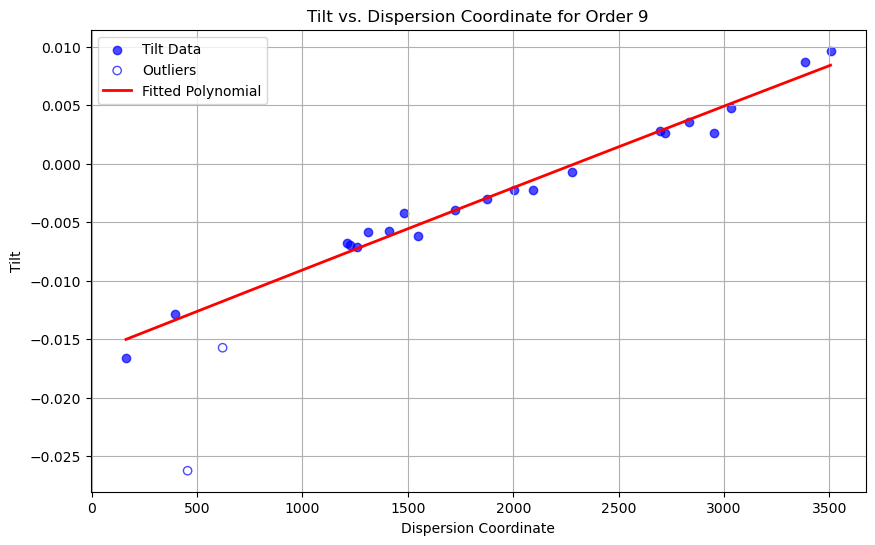

In [72]:
selected_order = 9  # Replace with the desired order number

# Filter data for the selected order
mask = (order_numbers == selected_order) & z_mask
y_coords_order = line_positions[mask, 1]  # Dispersion coordinates
z_values_order = tilt_values[mask]        # Tilt values

# Get the fitted polynomial for the selected order
if selected_order in order_fits:
    coeffs = order_fits[selected_order]
    y_fit = np.linspace(y_coords_order.min(), y_coords_order.max(), 500)
    z_fit = np.polyval(coeffs, y_fit)

    # Plot the tilt vs. dispersion coordinate and the fitted polynomial
    plt.figure(figsize=(10, 6))
    # plt.scatter(y_coords_order, z_values_order, label='Tilt Data', color='blue', alpha=0.7)
    plt.scatter(y_coords_order[order_masks[selected_order]], z_values_order[order_masks[selected_order]], label='Tilt Data', color='blue', alpha=0.7)
    plt.scatter(y_coords_order[~order_masks[selected_order]], z_values_order[~order_masks[selected_order]], label='Outliers', color='blue', facecolor='None', edgecolor='blue', alpha=0.7)
    plt.plot(y_fit, z_fit, label='Fitted Polynomial', color='red', linewidth=2)
    plt.xlabel('Dispersion Coordinate')
    plt.ylabel('Tilt')
    plt.title(f'Tilt vs. Dispersion Coordinate for Order {selected_order}')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print(f"No fitted polynomial available for order {selected_order}.")

In [73]:
# Define the range of dispersion coordinates
dispersion_range = np.arange(data.shape[0])

# Initialize variables to store the global max and min
global_max = -np.inf
global_min = np.inf

# Iterate over the fitted polynomials for each order
for order, coeffs in order_fits.items():
    # Evaluate the polynomial over the dispersion range
    
    fitted_values = np.polyval(coeffs, dispersion_range)
    
    # Update global max and min
    global_max = max(global_max, fitted_values.max())
    global_min = min(global_min, fitted_values.min())

print(f"Maximum value in dispersion direction: {global_max}")
print(f"Minimum value in dispersion direction: {global_min}")

Maximum value in dispersion direction: 0.025408555432154107
Minimum value in dispersion direction: -0.029689435542168022


In [74]:
determined_slopes = [np.polyval(coeffs, trace_y) for trace_y in traces.y]

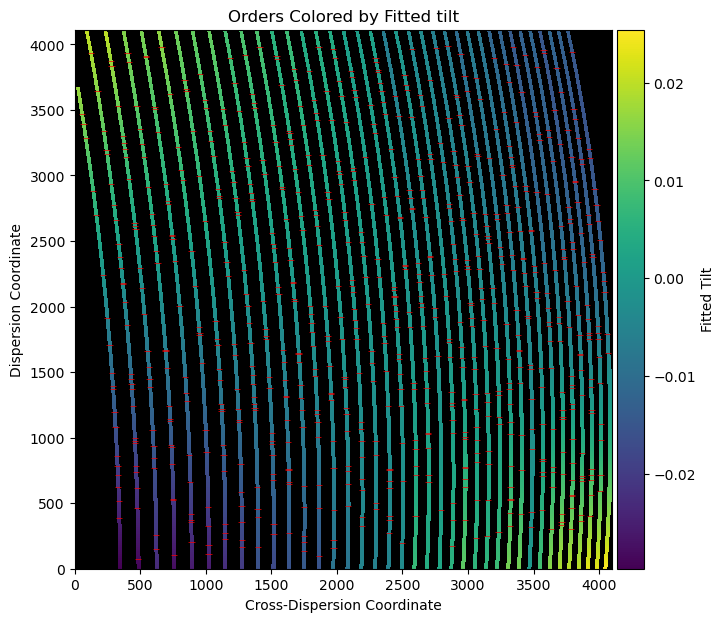

In [75]:
proxy_data = np.zeros_like(data, dtype=float)
mask = np.zeros_like(data, dtype=bool)
lower_mod, upper_mod = 24, 21

# Iterate over traces and apply the polynomial fit to calculate proxy data
n = 0
for trace_y, trace_x, lower, upper in zip(traces.y, traces.x, traces.summing_ranges_lower, traces.summing_ranges_upper):
    n+=1
    if n in order_fits:
        coeffs = order_fits[n]
        for y, x in zip(trace_y, trace_x):
            x_min = int(x - lower_mod)
            x_max = int(x + upper_mod)
            mask[int(y), x_min:x_max] = True
            proxy_data[int(y), x_min:x_max] = np.polyval(coeffs, y)

# Apply the mask to proxy_data
masked_proxy_data = np.ma.masked_where(~mask, proxy_data)

fig, ax = plt.subplots(figsize=(10, 7))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

# Plot the masked proxy data as a colormap
im = ax.imshow(masked_proxy_data, cmap='viridis', origin='lower')
fig.colorbar(im, cax=cax, orientation='vertical', label='Fitted Tilt')
ax.set_title('Orders Colored by Fitted tilt')
ax.set_xlabel('Cross-Dispersion Coordinate')
ax.set_ylabel('Dispersion Coordinate')
ax.set_facecolor('black')
ax.set_ylim(0, data.shape[0])
ax.set_xlim(0, data.shape[1])

# Overlay the line positions
for line in line_positions[np.isfinite(tilt_values)]:
    ax.hlines(line[1], xmin=line[0] - lower_mod-2, xmax=line[0] + upper_mod+1, colors='red', linestyles='-', linewidth=0.5)

plt.show()

##### Surface tilt approx

In [46]:
def fit_smooth_polynomial_surface(x_coords, y_coords, z_values, degree=5, sigma_clip=3.0, grid_shape=(100, 100)):
    # Use robust scaling to handle outliers better
    X = np.column_stack([x_coords, y_coords])
    
    # Create pipeline with robust preprocessing
    model = Pipeline([
        ('scaler', RobustScaler()),  # More robust to outliers than StandardScaler
        ('poly', PolynomialFeatures(degree=degree, include_bias=True)),
        ('ridge', Ridge(alpha=1.0))  # Higher regularization for smoothness
    ])
    
    # Fit model
    model.fit(X, z_values)
    residuals = z_values - model.predict(X)
    init_residuals_std = np.std(residuals)
    
    max_iterations = 100
    inlier_mask = residuals < sigma_clip * np.std(residuals)
    for iteration in range(max_iterations):
        model.fit(X[inlier_mask], z_values[inlier_mask])
        residuals = z_values - model.predict(X)
        std_dev = np.std(residuals[inlier_mask])
        new_mask = np.abs(residuals) < sigma_clip * std_dev
        if np.array_equal(inlier_mask, new_mask):
            print(f"Converged.")
            break
        inlier_mask = new_mask
    print(f"Std of residuals droped from {init_residuals_std:.2e} to {std_dev:.2e} after {iteration} iterations.")

    
    # Create evaluation grid
    # x_grid = np.linspace(0, grid_limits[0], grid_shape[0])
    x_grid = np.unique(x_coords)
    # Create grid based on the range of input x_coords and y_coords
    x_grid = np.linspace(np.min(x_coords), np.max(x_coords), grid_shape[0])
    y_grid = np.linspace(np.min(y_coords), np.max(y_coords), grid_shape[1])
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    grid_shape = X_grid.shape
    grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
    
    # Predict
    Z_grid = model.predict(grid_points).reshape(grid_shape)
    
    return X_grid, Y_grid, Z_grid, residuals, inlier_mask, model

In [47]:
mask = np.all(np.isfinite(tilt), axis=1)
y_coords = line_positions[mask, 1]
x_coords = line_positions[mask, 0]
# x_coords = order_numbers[mask]
z_values = tilt_values[mask]
# Z, residuals, inlier_mask, model = fit_surface_sklearn(x_coords, y_coords, z_values, degree=3, sigma_clip=3.0, robust=False, seed=30)
n_grid_points = len(np.unique(order_numbers))

In [63]:
X_grid, Y_grid, Z_grid, residuals, inlier_mask, model = fit_smooth_polynomial_surface(x_coords, y_coords, z_values, degree=2, sigma_clip=3.0, grid_shape=(n_grid_points, n_grid_points))

Converged.
Std of residuals droped from 4.39e-03 to 1.93e-03 after 4 iterations.


In [64]:
np.sum(inlier_mask), np.sum(mask), np.sum(inlier_mask)/np.sum(mask)*100

(766, 807, 94.91945477075589)

In [ ]:
# plt.close('all')

# fig = plt.figure(figsize=(10, 7))le_tilted_slit_extr
# ax = fig.add_subplot(111, projection='3d')

# # Plot fitted surface
# X, Y = np.meshgrid(np.unique(x_coords), np.arange(0, 4112, 100))
# ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, linewidth=0, antialiased=False)

# # Plot input data points
# ax.scatter(x_coords, y_coords, z_values, c='k', s=10, label='Input data', alpha=0.4)
# # ax.scatter(x_coords[inlier_mask], y_coords[inlier_mask], z_values[inlier_mask], c='r', s=10, label='Input data', alpha=0.4)

# ax.set_ylabel('Pixel')
# ax.set_xlabel('Order')
# ax.set_zlabel('Tilt')
# ax.set_title('Fitted Surface and Input Data')
# ax.legend()
# plt.show()

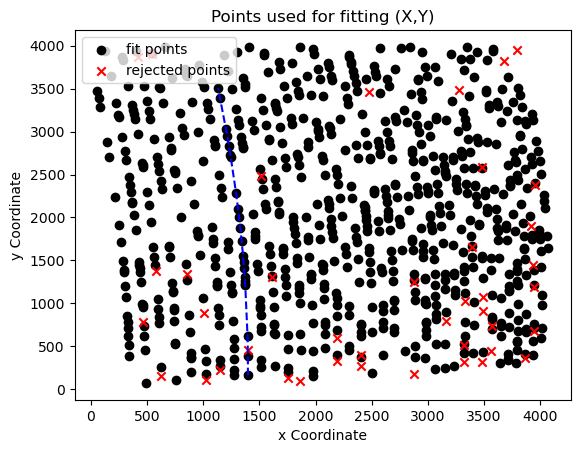

In [65]:
plt.close('all')
order = 9

fig, ax = plt.subplots()
ax.scatter(x_coords[inlier_mask], y_coords[inlier_mask], color='k', marker='o', label='fit points')
ax.scatter(x_coords[~inlier_mask], y_coords[~inlier_mask], color='r', marker='x', label='rejected points')
order_mask = order_numbers[mask] == order
sorted_indecies = np.argsort(y_coords[order_mask])
ax.plot(x_coords[order_mask][sorted_indecies], y_coords[order_mask][sorted_indecies], 'b--')
ax.set_ylabel('y Coordinate')
ax.set_xlabel('x Coordinate')
ax.set_title('Points used for fitting (X,Y)')
plt.legend()
plt.show()

In [52]:
# %matplotlib widget

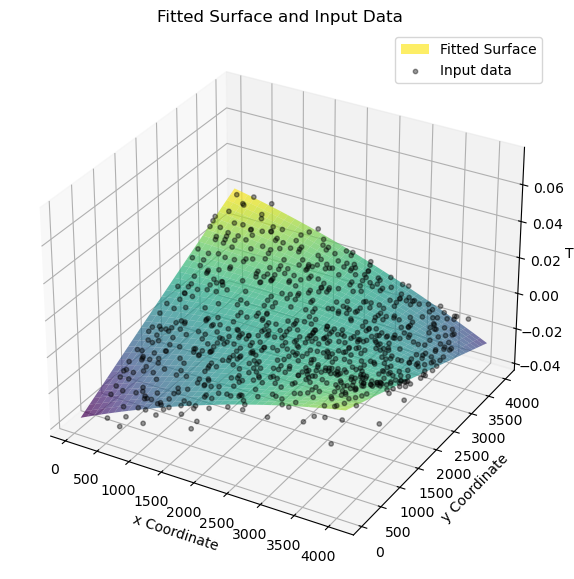

In [66]:
plt.close('all')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot fitted surface
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', alpha=0.7, label='Fitted Surface')

# Plot input data points (filtered by z_mask)
scatter = ax.scatter(
	x_coords, y_coords, z_values,
	c='k', s=10, label='Input data', alpha=0.4)

ax.set_ylabel('y Coordinate')
ax.set_xlabel('x Coordinate')
ax.set_zlabel('Tilt')
ax.set_title('Fitted Surface and Input Data')
ax.legend()
plt.show()

In [54]:
np.sum(residuals[inlier_mask] > 0), np.sum(residuals[inlier_mask] < 0)

(380, 348)

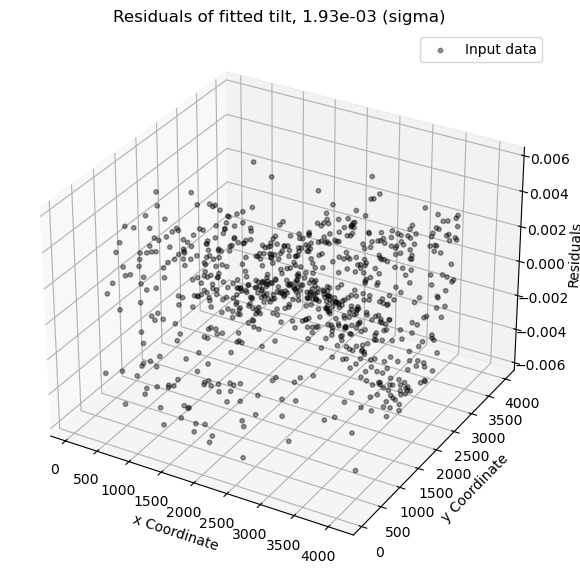

In [67]:
plt.close('all')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot input data points (filtered by z_mask)
scatter = ax.scatter(
	x_coords[inlier_mask], y_coords[inlier_mask], residuals[inlier_mask],
	c='k', s=10, label='Input data', alpha=0.4)

ax.set_ylabel('y Coordinate')
ax.set_xlabel('x Coordinate')
ax.set_zlabel('Residuals')
ax.set_title(f'Residuals of fitted tilt, {np.std(residuals[inlier_mask]):.2e} (sigma)')
ax.legend()
plt.show()

In [56]:
plt.close()

In [68]:
determined_slopes = [model.predict(np.column_stack([trace_x, trace_y])) for trace_x, trace_y in zip(traces.x, traces.y)]

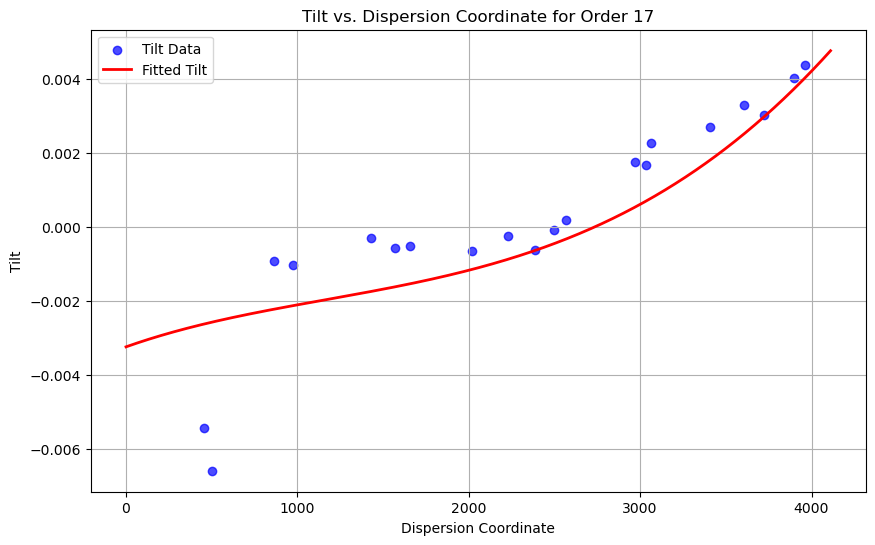

In [69]:
selected_order = 17  # Replace with the desired order number

# Get the fitted polynomial for the selected order
if selected_order in np.unique(order_numbers):
    # Filter data for the selected order
    order_mask = (order_numbers == selected_order) #& mask
    y_coords_order = line_positions[order_mask, 1]  # Dispersion coordinates
    z_values_order = tilt_values[order_mask]        # Tilt values


    y_fit = traces.y[selected_order-1]
    z_fit = determined_slopes[selected_order-1]

    # Plot the tilt vs. dispersion coordinate and the fitted polynomial
    plt.figure(figsize=(10, 6))
    # plt.scatter(y_coords_order, z_values_order, label='Tilt Data', color='blue', alpha=0.7)
    plt.scatter(y_coords_order, z_values_order, label='Tilt Data', color='blue', alpha=0.7)
    # plt.scatter(y_coords_order[~order_masks[selected_order]], z_values_order[~order_masks[selected_order]], label='Outliers', color='blue', facecolor='None', edgecolor='blue', alpha=0.7)
    plt.plot(y_fit, z_fit, label='Fitted Tilt', color='red', linewidth=2)
    plt.xlabel('Dispersion Coordinate')
    plt.ylabel('Tilt')
    plt.title(f'Tilt vs. Dispersion Coordinate for Order {selected_order}')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print(f"There is no such order. Orders are in range ({np.min(np.unique(order_numbers))}, {np.max(np.unique(order_numbers))}).")

### Tiltet aperture spectra extraction

In [74]:
%matplotlib inline

In [ ]:
# def resample_spectrum_orders(frame, traces, tilts, n_sub=3, dispersion_oversample=1):
#     resampled_orders = []
#     for i, (trace_y, trace_x, lower, upper) in enumerate(traces):
#         if dispersion_oversample == 1:
#             _trace_y = np.asarray(trace_y)
#             _trace_x = np.asarray(trace_x)
#             tilt = tilts[i]
#         else:
#             _trace_y = np.linspace(trace_y[0], trace_y[-1], len(trace_y) * dispersion_oversample)
#             interp_x = interp1d(trace_y, trace_x, kind='cubic', fill_value='extrapolate', bounds_error=False)
#             _trace_x = interp_x(_trace_y)
#             interp_tilt = interp1d(trace_y, tilts[i], kind='cubic', fill_value='extrapolate', bounds_error=False)
#             tilt = interp_tilt(_trace_y)

#         # Oversample along the slit (spatial) direction
#         slit_offsets = np.linspace(-lower, upper, (lower + upper) * n_sub)

#         # norm = np.sqrt(1 + tilt**2)
#         dx = slit_offsets[:, None] #* (1 / norm)
#         # dy = slit_offsets[:, None] * (tilt / norm)
#         dy = slit_offsets[:, None] * tilt

#         x_sample = _trace_x + dx
#         y_sample = _trace_y + dy

#         resampled = np.sum(map_coordinates(frame, [y_sample, x_sample], order=5, mode='nearest'), axis=0)/n_sub

#         # Interpolate resampled data back to the original trace_y grid if oversampled
#         if dispersion_oversample != 1:
#             interp_resampled = interp1d(_trace_y, resampled, kind='cubic', bounds_error=False, fill_value='extrapolate', axis=0)
#             resampled = interp_resampled(trace_y)
#         resampled_orders.append(resampled)
#     return resampled_orders


In [ ]:
# def drizzle_rectified_2D(image, trace_x, trace_y, tilt_array, lower=5, upper=5, dispersion_oversample=1):
#     """
#     Drizzle-based rectification and extraction of a 2D spectrum with tilted slit.
    
#     Parameters:
#         image         : 2D array (ny, nx), detector image
#         trace_x       : 1D array of x positions (one per y row)
#         tilt_array    : 1D array of slopes (dy/dx), same length as trace_x
#         lower, upper  : limits (in pixels) from trace center to integrate across slit
#         pixel_fraction: fraction of pixel size to drizzle (1.0 = full pixel footprint)

#     Returns:
#         rectified     : 2D array [spatial, dispersion]
#         weight        : 2D array of accumulated weights (for normalization)and Input Data
#         spectrum_1D   : 1D array (dispersion) — sum over spatial axis
#     """
#     """
#     Drizzle-based rectification and extraction of a 2D spectrum with tilted slit.
    
#     Parameters:
#         image         : 2D array (ny, nx), detector image
#         trace_x       : 1D array of x positions (one per y row)
#         tilt_array    : 1D array of slopes (dy/dx), same length as trace_x
#         lower, upper  : limits (in pixels) from trace center to integrate across slit
#         pixel_fraction: fraction of pixel size to drizzle (1.0 = full pixel footprint)

#     Returns:
#         rectified     : 2D array [spatial, dispersion]
#         weight        : 2D array of accumulated weights (for normalization)
#         spectrum_1D   : 1D array (dispersion) — sum over spatial axis
#     """
#     ny, nx = image.shape
#     n_disp = len(trace_y)
#     n_disp_out = n_disp * dispersion_oversample
#     slit_width = int(np.ceil(lower + upper)) + 1

#     y_out = np.linspace(np.min(trace_y), np.max(trace_y), n_disp_out)
#     # trace_x_interp = np.interp1d(trace_y, trace_x, kind='cubic')(y_out)
#     trace_x_interp = interp1d(trace_y, trace_x, kind='cubic')
#     # tilt_interp = np.interp1d(trace_y, tilt_array, kind='cubic')(y_out)
#     tilt_interp = interp1d(trace_y, tilt_array, kind='cubic')

#     rectified = np.zeros((slit_width, n_disp_out), dtype=np.float64)
#     weight = np.zeros_like(rectified)

#     pixel_fraction = 1/dispersion_oversample

#     # for y in trace_y:
#     for i, y in enumerate(y_out):
#         # y = int(y)
#         y_low = int(np.floor(y))
#         y_high = y_low+1
#         frac = y - y_low

#         if 0 <= y_low < ny and 1 < y_high <= ny:
#             # x_c = trace_x_interp[i]
#             # a = tilt_interp[i]
#             img_row = (1-frac) * image[y_low] + frac*image[y_high]
#             x_c = trace_x_interp(y)
#             a = tilt_interp(y)

#             # Unit vector along slit direction: perpendicular to trace, using slope dy/dx = a
#             # Tilt direction is [1, a] in (x, y), so normal slit direction is [a, -1]
#             # v_slit = np.array([a, -1])
#             v_slit = np.array([1, a])
#             v_slit = v_slit / np.linalg.norm(v_slit)  # normalize

#             # Integration over x around trace_x[y]
#             x_start = int(np.floor(x_c - lower))
#             x_end   = int(np.ceil(x_c + upper))

#             for x in range(x_start, x_end + 1):
#                 if 0 <= x < nx:
#                     # Pixel center vector
#                     vec = np.array([x - x_c, 0])  # pixel center offset from trace center
#                     slit_offset = np.dot(vec, v_slit)  # project onto slit direction

#                     if -lower <= slit_offset <= upper:
#                         i_slit = int(np.floor(slit_offset + lower))
#                         if 0 <= i_slit < slit_width:
#                             # flux = image[y, x]
#                             flux = img_row[x]
#                             rectified[i_slit, i] += flux * pixel_fraction**2
#                             weight[i_slit, i] += pixel_fraction**2

#     # Normalize by weight
#     with np.errstate(divide='ignore', invalid='ignore'):
#         rectified_norm = np.where(weight > 0, rectified / weight, 0.0)

#     # Optionally collapse to 1D spectrum
#     spectrum_1D = interp1d(y_out, np.sum(rectified_norm, axis=0), kind='cubic')(trace_y)

#     return rectified_norm, weight, spectrum_1D
#     # return spectrum_1D


In [ ]:
def extract_tilted_slit_spectrum(
    frame,
    trace_x,
    trace_y,
    tilt_array,
    lower,
    upper,
    subsample=5,
    pixel_sigma=0.5,
    weight_mode = 'gaussian'
):
    """
    Extract a 1D spectrum along a tilted slit using subpixel Gaussian weighting.

    Parameters
    ----------
    frame : 2D array
        Input 2D image (counts).
    trace_x : 1D array
        x positions of slit center (along trace_y).
    trace_y : 1D array
        y positions of slit (dispersion direction).
    tilt_array : 1D array
        Slope (dy/dx) of the slit at each trace point.
    lower : float
        Pixels to include below the trace center in x (cross-dispersion).
    upper : float
        Pixels to include above the trace center in x.
    subsample : int
        Number of subpixels per axis (e.g. 5 means 5×5 grid per pixel).
    pixel_sigma : float
        Standard deviation of Gaussian weighting kernel (in pixels).
    return_weights : bool
        If True, also return the accumulated weight sum.

    Returns
    -------
    spectrum : 1D array
        Extracted, weighted 1D spectrum (same length as trace_y).
    weights (optional) : 1D array
        Weight sums at each trace_y (can be used for diagnostics).
    """

    ylen, xlen = frame.shape
    spectrum = np.zeros(len(trace_y))
    weight_sum = np.zeros(len(trace_y))

    # Subpixel grid
    step = 1.0 / subsample
    offsets = np.linspace(-0.5 + step / 2, 0.5 - step / 2, subsample)
    dx_grid, dy_grid = np.meshgrid(offsets, offsets)
    dx_grid = dx_grid.ravel()
    dy_grid = dy_grid.ravel()

    for i, (x0, y0, slope) in enumerate(zip(trace_x, trace_y, tilt_array)):
        # Slit direction vector
        slit_vec = np.array([1.0, slope])
        slit_vec /= np.linalg.norm(slit_vec)

        # Normal vector (perpendicular to slit)
        normal_vec = np.array([-slope, 1.0])
        normal_vec /= np.linalg.norm(normal_vec)

        # Define bounding box in x
        x_min = int(np.floor(x0 - lower)) - 1
        x_max = int(np.ceil(x0 + upper)) + 1
        y_min = int(np.floor(y0 - abs(slope) * max(lower, upper))) - 1
        y_max = int(np.ceil(y0 + abs(slope) * max(lower, upper))) + 1

        # Clip to frame
        x_min = max(0, x_min)
        x_max = min(xlen, x_max)
        y_min = max(0, y_min)
        y_max = min(ylen, y_max)

        for y_pix in range(y_min, y_max):
            if not (0 <= y_pix <= ylen):
                continue
            for x_pix in range(x_min, x_max):
                if not (0 <= x_pix <= xlen):
                    continue

                flux = frame[y_pix, x_pix]
                for dx_sub, dy_sub in zip(dx_grid, dy_grid):
                    # Subpixel position
                    x = x_pix + dx_sub
                    y = y_pix + dy_sub

                    # Position relative to slit center
                    dx = x - x0
                    dy = y - y0

                    # Project onto normal (cross-dispersion)
                    d_normal = dx * normal_vec[0] + dy * normal_vec[1]
                    # Project along the slit (dispersion)
                    d_slit = dx * slit_vec[0] + dy * slit_vec[1]


                    # if -lower <= d_slit <= upper and -0.5 <= d_normal <= 0.5:
                    if -lower <= d_slit <= upper: 
                        if weight_mode == 'gaussian':
                            # Weight from Gaussian kernel
                            w = np.exp(-0.5 * (d_normal / pixel_sigma) ** 2)
                            w /= (np.sqrt(2*np.pi) * pixel_sigma)  # normalize area
                        elif weight_mode == 'tophat':
                            w = 1 if -0.5 <= d_normal <= 0.5 else 0
                        else:
                            raise ValueError("Selected weight_mode is invalid.")
                            # w = 1
                            # print(f"[Warning]: The {weight_mode} weight mode is currently not implemented using equal weight for each subpixel")

                        spectrum[i] += flux * w / (subsample**2)
                        weight_sum[i] += w / (subsample**2)

    # Normalize to get final weighted spectrum
    # spectrum = np.divide(
    #     spectrum,
    #     weight_sum,
    #     out=np.zeros_like(spectrum),
    #     where=weight_sum != 0,
    # )

    # if return_weights:
    #     return spectrum, weight_sum
    return spectrum

In [ ]:
# def drizzle_tilted_slit_extraction_asymmetric(
#     frame,
#     trace_x,
#     trace_y,
#     tilt_array,
#     lower=5,
#     upper=5,
#     oversample_y=1,
#     oversample_x=1,
#     pixel_sigma=0.5,
# ):
#     """
#     Drizzle-style tilted slit extraction with oversampling, Gaussian weighting,
#     asymmetric slit bounds, and cropped spatial window.

#     Parameters
#     ----------
#     frame : 2D array
#         Input image (counts).
#     trace_x : 1D array
#         x positions of the slit center (along trace_y).
#     trace_y : 1D array
#         y positions along the slit (same length as trace_x).
#     tilt_array : 1D array
#         Slope dy/dx of the slit at each point (same length as trace_x).
#     lower : float
#         Lower spatial bound (pixels below trace_x).
#     upper : float
#         Upper spatial bound (pixels above trace_x).
#     oversample_y : int
#         Oversampling factor in the dispersion (y) direction.
#     oversample_x : int
#         Oversampling factor in the spatial (x) direction.
#     pixel_sigma : float
#         Standard deviation for Gaussian weighting (in original pixels).

#     Returns
#     -------
#     flux_grid : 2D array
#         Rectified, oversampled 2D extraction grid (x_oversampled, y_oversampled).
#     weight_grid : 2D array
#         Weights accumulated (for normalization).
#     y_grid : 1D array
#         Oversampled dispersion coordinate.
#     x_grid : 1D array
#         Oversampled spatial coordinate, centered on trace.
#     """

#     ny, nx = frame.shape
#     trace_len = len(trace_x)

#     os_ny = trace_len * oversample_y
#     spatial_extent = lower + upper
#     os_nx = int(np.ceil(spatial_extent * oversample_x))

#     flux_grid = np.zeros((os_nx, os_ny), dtype=np.float64)
#     weight_grid = np.zeros_like(flux_grid)

#     y_grid = np.linspace(trace_y[0], trace_y[-1], os_ny)
#     x_grid = np.linspace(-lower, upper, os_nx, endpoint=False)

#     x_pixel, y_pixel = np.meshgrid(np.arange(nx), np.arange(ny))

#     for i in range(os_ny):
#         y_c = y_grid[i]
#         x_c = np.interp(y_c, trace_y, trace_x)
#         slope = np.interp(y_c, trace_y, tilt_array)

#         slit_vec = np.array([1.0, slope])
#         slit_vec /= np.linalg.norm(slit_vec)
#         normal_vec = np.array([-slope, 1.0])
#         normal_vec /= np.linalg.norm(normal_vec)

#         x_min = int(np.floor(x_c - lower - 1))
#         x_max = int(np.ceil(x_c + upper + 1))
#         y_min = int(np.floor(y_c - spatial_extent))
#         y_max = int(np.ceil(y_c + spatial_extent))

#         x_min = max(x_min, 0)
#         x_max = min(x_max, nx)
#         y_min = max(y_min, 0)
#         y_max = min(y_max, ny)

#         x_sub, y_sub = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
#         x_rel = x_sub.ravel()
#         y_rel = y_sub.ravel()
#         flux_rel = frame[y_min:y_max, x_min:x_max].ravel()

#         dx = x_rel - x_c
#         dy = y_rel - y_c

#         offset_along = dx * slit_vec[0] + dy * slit_vec[1]
#         offset_perp = dx * normal_vec[0] + dy * normal_vec[1]

#         mask = (offset_perp >= -lower) & (offset_perp <= upper)
#         if not np.any(mask):
#             continue

#         x_os = (offset_perp[mask] + lower) * oversample_x
#         x_idx = np.floor(x_os).astype(int)

#         valid = (x_idx >= 0) & (x_idx < os_nx)
#         if not np.any(valid):
#             continue

#         weights = np.exp(-0.5 * (offset_perp[mask][valid] / pixel_sigma) ** 2)
#         values = flux_rel[mask][valid] * weights

#         np.add.at(flux_grid, (x_idx[valid], i), values)
#         np.add.at(weight_grid, (x_idx[valid], i), weights)

#     return flux_grid, weight_grid, y_grid, x_grid
#     # return flux_grid, weight_grid, os_ny


In [103]:
def make_slit_polygon_vector(center_x, center_y, slit_vec, normal_vec, lower, upper, half_width):
    """
    Return 4 corners of the tilted rectangle slit centered at (center_x, center_y).
    """
    # Four corners: (lower, -half_width), (upper, -half_width), (upper, +half_width), (lower, +half_width)
    center_x+=0.5
    center_y+=0.5
    p1 = [center_x, center_y] + (-half_width * normal_vec - lower * slit_vec)
    p2 = [center_x, center_y] + (-half_width * normal_vec + upper * slit_vec)
    p3 = [center_x, center_y] + ( half_width * normal_vec + upper * slit_vec)
    p4 = [center_x, center_y] + ( half_width * normal_vec - lower * slit_vec)
    # if print_corners:
    #     print(-half_width * normal_vec - lower * slit_vec)
    #     print( half_width * normal_vec - upper * slit_vec)
    #     print( half_width * normal_vec + upper * slit_vec)
    #     print(-half_width * normal_vec + lower * slit_vec)
    #     print(p1, p2, p3, p4)
    return np.array([p1, p2, p3, p4])

In [104]:
def compute_overlap_weights(slit_polygon, x_min, x_max, y_min, y_max):
    """
    Compute the overlap area between a slit polygon and all pixels in a region.
    Returns:
        - pixel_xs, pixel_ys: integer grid coordinates of pixels
        - areas: corresponding overlap area (same shape)
    """
    pixel_xs, pixel_ys = np.meshgrid(np.arange(x_min, x_max),
                                     np.arange(y_min, y_max),
                                     indexing='xy')
    pixel_xs = pixel_xs.flatten()
    pixel_ys = pixel_ys.flatten()

    areas = np.zeros_like(pixel_xs, dtype=np.float32)

    for i, (x, y) in enumerate(zip(pixel_xs, pixel_ys)):
        # pixel_poly = ShapelyBox(x - 0.5, y - 0.5, x + 0.5, y + 0.5)
        pixel_poly = ShapelyBox(x, y, x + 1, y + 1)
        intersection = slit_polygon.intersection(pixel_poly)
        if not intersection.is_empty:
            areas[i] = intersection.area

    return pixel_xs, pixel_ys, areas

In [ ]:
def tilted_slit_extraction(frame, trace_x, trace_y, tilt_array,
                           lower, upper, plot=False):
    """
    Extract 1D spectrum from 2D frame using tilted slit extraction.

    Parameters
    ----------
    frame : 2D numpy array
        Input image data.
    trace_x, trace_y : 1D arrays
        Trace coordinates. trace_y is dispersion axis indices,
        trace_x is spatial coordinate at each y.
    tilt_array : 1D array
        Slit tilt at each y (slope dy/dx or a in y = a*x).
    lower, upper : scalar ints
        Pixel range around trace_x to include in spatial direction.
    oversample_y, oversample_x : int
        Oversampling factors for dispersion and spatial directions.

    Returns
    -------
    spectrum : 1D array
        Extracted spectrum of length len(trace_y).
    """

    ylen, xlen = frame.shape
    half_width = 0.5
    
    spectrum = np.zeros_like(trace_y, dtype=np.float64)
    weights = []

    # Loop over dispersion coordinate (y)
    for i, (x0, y0, slope) in enumerate(zip(trace_x, trace_y, tilt_array)):
        # Oversampled positions in y around y0
        slit_vec = np.array([1.0, slope])
        slit_vec /= np.linalg.norm(slit_vec)
        normal_vec = np.array([-slope, 1.0])
        normal_vec /= np.linalg.norm(normal_vec)

        slit = make_slit_polygon_vector(x0, y0, slit_vec, normal_vec, lower, upper, half_width)
        slit_polygon = ShapelyPolygon(slit)

        # Determine pixel bounding box indices (integer)
        minx, miny, maxx, maxy = slit_polygon.bounds
        x_min = max(int(np.floor(minx - 1)), 0)
        x_max = min(int(np.ceil(maxx + 1)), ylen - 1)
        y_min = max(int(np.floor(miny - 1)), 0)
        y_max = min(int(np.ceil(maxy + 1)), xlen - 1)

        flux = frame[y_min:y_max,x_min:x_max]

        pixel_xs, pixel_ys, areas = compute_overlap_weights(slit_polygon, x_min, x_max, y_min, y_max)
        
        if plot and i==2500:
            x_slit, y_slit = slit_polygon.exterior.xy
            print(slope)

            plt.close('all')
            fig, (ax1, ax2) = plt.subplots(2,1)
            ax1.imshow(flux, origin='lower', extent=[x_min, x_max, y_min, y_max])
            ax1.plot(x_slit, y_slit, color='red', linewidth=1.5)

            ax2.imshow(areas.reshape(y_max-y_min, x_max-x_min), origin='lower', extent=[x_min, x_max, y_min, y_max])
            ax2.plot(x_slit, y_slit, color='red', linewidth=1.5)
            # norm = Normalize(vmin=0, vmax=1.0)
            # cmap = plt.cm.viridis
            # for x, y, w in zip(pixel_xs-x_min, pixel_ys-y_min, areas):
            #     rect = Rectangle((x, y), 1, 1, facecolor=cmap(norm(w)), edgecolor='k', linewidth=0.1)
            #     ax2.add_patch(rect)
            plt.tight_layout()
            plt.show()

        spectrum[i] = np.sum(flux[pixel_ys-y_min, pixel_xs-x_min]*areas)
        weights.append(areas)

    return spectrum, weights

In [79]:
# resampled_orders = resample_spectrum_orders(data, traces, determined_slopes, n_sub=1, dispersion_oversample=3)

In [80]:
# rectified_norm, weight, resampled_order_spectrum = drizzle_rectified_2D(data, traces.x[4], traces.y[4], determined_slopes[4], traces.summing_ranges_lower[4], traces.summing_ranges_upper[4], dispersion_oversample=5)

In [81]:
# spectrum_1D, weight, oversampled_pixels, oversampled_slit = drizzle_tilted_slit_extraction_asymmetric(
#     data,
#     traces.x[4],
#     traces.y[4],
#     determined_slopes[4],
#     lower=traces.summing_ranges_lower[4],
#     upper=traces.summing_ranges_upper[4],
#     oversample_y=3,
#     oversample_x=3,
#     pixel_sigma=0.5)

In [ ]:
# spectrum_1D = extract_tilted_slit_spectrum(
#     data,
#     traces.x[4],
#     traces.y[4],
#     determined_slopes[4],print_corners
#     lower=traces.summing_ranges_lower[4],
#     upper=traces.summing_ranges_upper[4],
#     subsample=5,
#     pixel_sigma=0.5,
#     weight_mode='gaussian'
# )

In [106]:
%matplotlib widget

0.014291546946595507
POLYGON ((1608.8340624608388 499.59992859983527, 1662.8285486009906 500.37159333336456, 1662.8142585133326 501.37149122484885, 1608.819772373181 500.59982649131956, 1608.8340624608388 499.59992859983527))


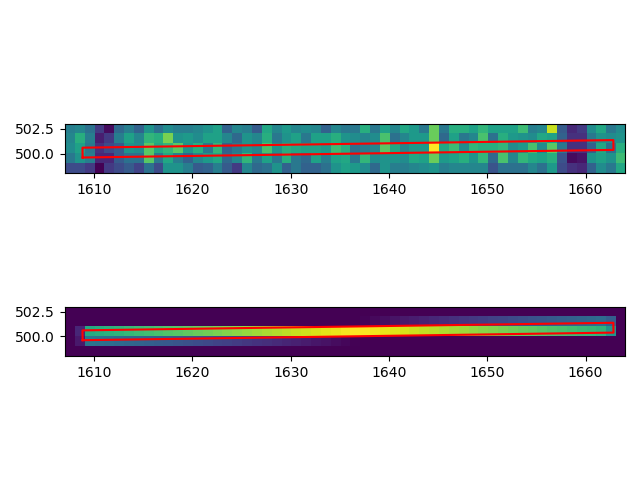

In [111]:
order = 10
spectrum_1D, weights = tilted_slit_extraction(data,
    traces.x[order],
    traces.y[order],
    determined_slopes[order],
    traces.summing_ranges_lower[order],
    traces.summing_ranges_upper[order],
    plot=True
    )

In [ ]:
# oversampled_pixels

array([0.00000000e+00, 3.33279273e-01, 6.66558547e-01, ...,
       4.10933344e+03, 4.10966672e+03, 4.11000000e+03])

In [165]:
determined_slopes[order]

array([-0.0038794 , -0.00386357, -0.00384777, ..., -0.00217747,
       -0.00218435, -0.00219125])

In [109]:
extracted_spectrum, extracted_img = veloce_reduction_tools.extract_orders_with_trace(data, traces)

In [62]:
%matplotlib widget

In [113]:
np.sum(resampled_orders[4], axis=0).shape

(4111,)

In [114]:
extracted_spectrum[4].shape

(4111,)

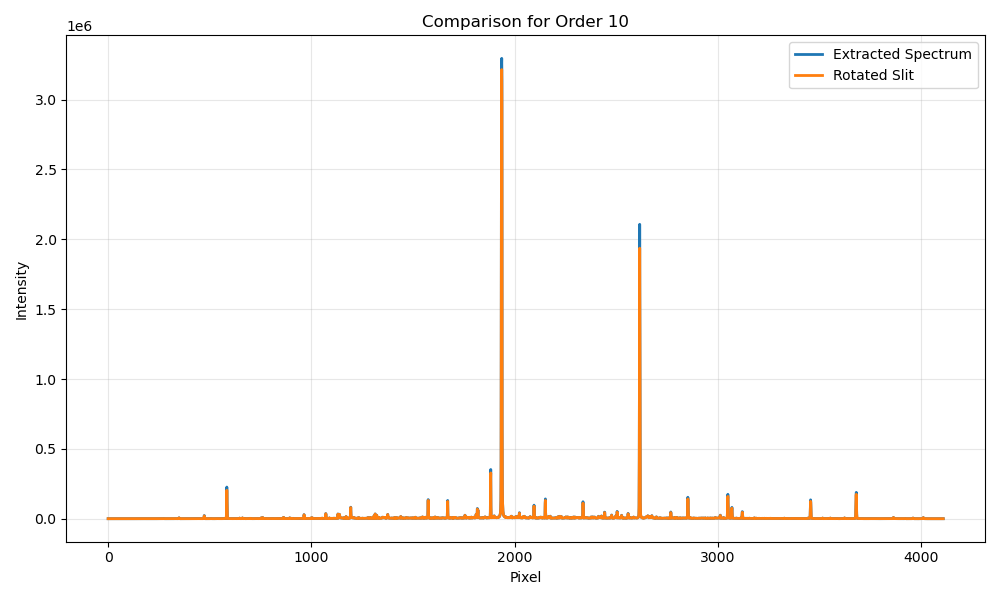

In [112]:
plt.close()
order = 10

fig, ax = plt.subplots(figsize=(10, 6))

# Plot extracted spectrum
ax.plot(extracted_spectrum[order], label='Extracted Spectrum', color='C0', linewidth=2)

# Plot resampled order (sum over spatial/slit axis)
# if resampled_orders[order].ndim == 2:
#     resampled_sum = np.sum(resampled_orders[order], axis=0)
#     ax.plot(resampled_sum, label='Resampled Order (summed)', color='C1', linestyle='-', linewidth=2)
# else:
#     ax.plot(resampled_orders[order], label='Resampled Order', color='C1', linestyle='-', linewidth=2)
# ax.plot(resampled_order_spectrum, label='Drizzle Spectrum', color='C1', linewidth=2)
# ax.plot(oversampled_pixels, np.sum(spectrum_1D, axis=0), label='Drizzle Spectrum', color='C1', linewidth=2)
# ax.plot(spectrum_1D*(max(extracted_spectrum[order])/max(spectrum_1D)), label='Rotated Slit', color='C1', linewidth=2)
ax.plot(spectrum_1D, label='Rotated Slit', color='C1', linewidth=2)

ax.set_title(f'Comparison for Order {order}')
ax.set_xlabel('Pixel')
ax.set_ylabel('Intensity')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [154]:
print(len(spectrum_1D), len(weights))

4111 4111


In [158]:
weights[row]

array([], dtype=float32)

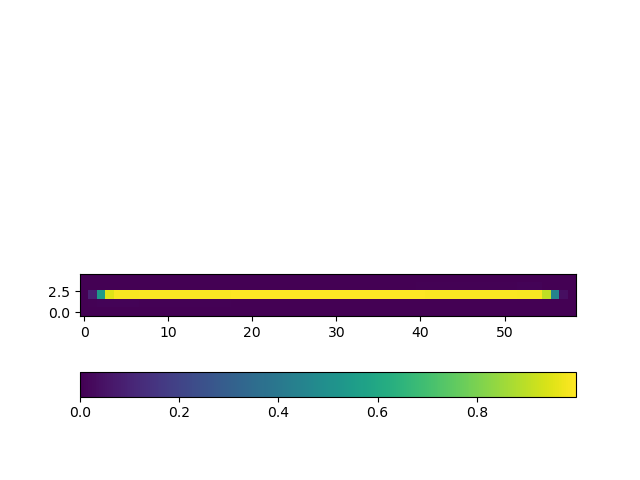

In [168]:
row = 410
plt.close('all')
x_shape = int((traces.summing_ranges_lower[order]+traces.summing_ranges_upper[order]+5))
y_shape = int(len(weights[row])/x_shape)
# px, py = np.meshgrid(np.arange(0, x_shape),
#                                      np.arange(0, y_shape),
#                                      indexing='xy')
# px = px.flatten()
# py = py.flatten()
# print(px.shape, py.shape, weights[row].shape)
plt.imshow(weights[row].reshape((y_shape,x_shape)), origin='lower')
# Plotting
# fig, ax = plt.subplots(figsize=(8, 8))
# norm = Normalize(vmin=0, vmax=1.0)
# cmap = plt.cm.viridis

# for x, y, w in zip(px, py, weights[row]):
#     rect = Rectangle((x, y), 1, 1, facecolor=cmap(norm(w)), edgecolor='k', linewidth=0.1)
#     ax.add_patch(rect)
plt.colorbar(orientation='horizontal')
# plt.xlim(0, x_shape)
# plt.ylim(0, y_shape)
plt.show()

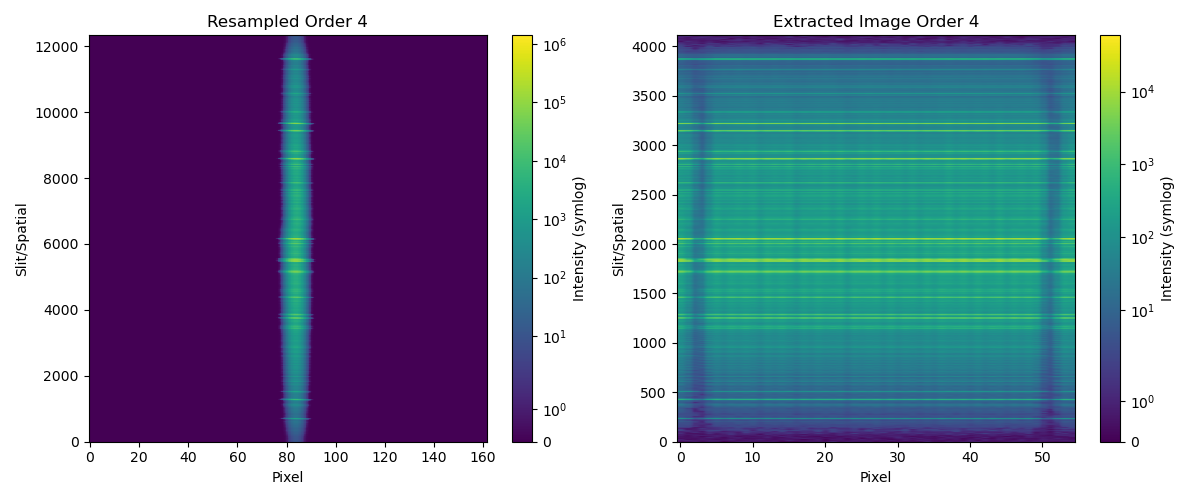

In [129]:
order = 4
plt.close('all')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot resampled order
# Plot resampled order with flipped axes and symlog normalization
# im0 = axes[0].imshow(
#     rectified_norm.T,  # flip axes
#     aspect='auto',
#     origin='lower',
#     cmap='viridis',
#     norm='symlog'
# )
im0 = axes[0].imshow(
    spectrum_1D.T,  # flip axes
    aspect='auto',
    origin='lower',
    cmap='viridis',
    norm='symlog'
)
axes[0].set_title(f'Resampled Order {order}')
axes[0].set_xlabel('Pixel')
axes[0].set_ylabel('Slit/Spatial')
fig.colorbar(im0, ax=axes[0], orientation='vertical', label='Intensity (symlog)')

# Plot extracted image with symlog normalization
im1 = axes[1].imshow(
    extracted_img[order],
    aspect='auto',
    origin='lower',
    cmap='viridis',
    norm='symlog'
)
axes[1].set_title(f'Extracted Image Order {order}')
axes[1].set_xlabel('Pixel')
axes[1].set_ylabel('Slit/Spatial')
fig.colorbar(im1, ax=axes[1], orientation='vertical', label='Intensity (symlog)')

# Plot extracted image
# axes[1].imshow(extracted_img[order], aspect='auto', origin='lower', cmap='viridis')
# axes[1].set_title(f'Extracted Image Order {order}')
# axes[1].set_xlabel('Pixel')
# axes[1].set_ylabel('Slit/Spatial')

plt.tight_layout()
plt.show()

In [8]:
np.linspace(-5, 5, 10)

array([-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
        0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ])

In [47]:
# def fit_surface(order_numbers, line_positions, tilt_values, image, degree=1):
#     """
#     Fit a surface to the offset map using least squares.

#     Fitting procedure inspired by: https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6
#     """
    
#     ymax, xmax = image.shape

#     # data = np.array([(x, y, z) for x, y, z in zip(order_numbers, line_positions[:,1], tilt_values)])
#     data = np.array([(x, y, z) for (x, y), z in zip(line_positions, tilt_values)])
    
#     grid_points = np.array([(x,y) for x in range(xmax) for y in range(ymax)])
#     # grid_points = np.array([(x,y) for x in range(max(order_numbers)) for y in range(ymax)])
#     # grid_points = np.vstack(grid_points)

#     # Perform iterative sigma clipping around the fitted surface
#     max_iterations = 10
#     sigma_threshold = 3.0
#     mask = np.ones(data.shape[0], dtype=bool)
#     mask *= ~np.isnan(data[:, 2]) 
#     for it in range(max_iterations):
#         if degree == 1:
#             A = np.c_[data[mask, 0], data[mask, 1], np.ones(data[mask].shape[0])]
#         elif degree == 2:
#             A = np.c_[data[mask, 0]**2, data[mask, 1]**2, data[mask, 0]*data[mask, 1], data[mask, 0], data[mask, 1], np.ones(data[mask].shape[0])]
#         elif degree == 3:
#             A = np.c_[data[mask, 0]**3, data[mask, 1]**3, data[mask, 0]**2 * data[mask, 1], data[mask, 0] * data[mask, 1]**2,
#                       data[mask, 0]**2, data[mask, 1]**2, data[mask, 0]*data[mask, 1], data[mask, 0], data[mask, 1], np.ones(data[mask].shape[0])]
#         else:
#             raise ValueError("Only polynomial orders 1, 2, or 3 are supported.")
        
#         C, _, _, _ = lstsq(A, data[mask, 2])

#         if degree == 1:
#             residuals = data[:, 2] - (C[0] * data[:, 0] + C[1] * data[:, 1] + C[2])
#         elif degree == 2:
#             residuals = data[:, 2] - (C[0] * data[:, 0]**2 + C[1] * data[:, 1]**2 + C[2] * data[:, 0] * data[:, 1] +
#              C[3] * data[:, 0] + C[4] * data[:, 1] + C[5])
#         elif degree == 3:
#             residuals = data[:, 2] - (C[0] * data[:, 0]**3 + C[1] * data[:, 1]**3 + C[2] * data[:, 0]**2 * data[:, 1] +
#              C[3] * data[:, 0] * data[:, 1]**2 + C[4] * data[:, 0]**2 + C[5] * data[:, 1]**2 +
#              C[6] * data[:, 0] * data[:, 1] + C[7] * data[:, 0] + C[8] * data[:, 1] + C[9])
            
#         std_dev = np.std(residuals[mask])
#         new_mask = np.abs(residuals) < sigma_threshold * std_dev
#         if np.array_equal(mask, new_mask):
#             break

#         mask = new_mask

#     if degree == 1:
#         z = [C[0]*x + C[1]*y + C[2] for x, y in grid_points]
#     elif degree == 2:
#         z = [C[0]*x**2 + C[1]*y**2 + C[2]*x*y + C[3]*x + C[4]*y + C[5] for x, y in grid_points]
#     elif degree == 3:
#         z = [C[0]*x**3 + C[1]*y**3 + C[2]*x**2*y + C[3]*x*y**2 + C[4]*x**2 + C[5]*y**2 +
#              C[6]*x*y + C[7]*x + C[8]*y + C[9] for x, y in grid_points]

#     Z = np.array(z).reshape(image.shape)
#     # Z = np.array(z).reshape([ymax, max(order_numbers)])

#     return Z, C, data[mask], residuals[mask]

In [48]:
# flattened_line_positions = np.array([pos for order in line_positions for pos in order])
# tilt_values = np.array([element[0] for order in tilt for element in order])

In [49]:
# Z, C, masked_points, residuals = fit_surface(flattened_line_positions, tilt_values, data, degree=1)
# surface_points, coeffs, filtered_points, residuals = fit_surface(order_numbers, line_positions, tilt_values, data, degree=3)

In [50]:
# results = []
# for degree in range(1, 4):
#     fit_result = fit_surface(line_positions, tilt_values, data, degree=degree)
#     print(np.std(fit_result[3]))
#     results.append(fit_result)

# # Select the result with the smallest standard deviation of residuals
# best_fit = min(results, key=lambda result: np.std(result[3]))
# surface_points, coeffs, filtered_points, residuals = best_fit

In [51]:
# %matplotlib inline

In [52]:
# # Create a mask for the region within +upper and -lower of the trace
# mask = np.zeros_like(surface_points, dtype=bool)
# for trace_y, trace_x, lower, upper in traces:
#     for y, x in zip(trace_y, trace_x):
#         x_min = int(x - lower)
#         x_max = int(x + upper)
#         mask[int(y), x_min:x_max] = True
        
# # Apply the mask to Z
# masked_surface_points = np.ma.masked_where(~mask, surface_points)

# fig, ax = plt.subplots(figsize=(10, 7))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)

# # Plot the masked Z as a colormap
# # plt.figure()
# im = ax.imshow(masked_surface_points, cmap='viridis', origin='lower')
# fig.colorbar(im, cax=cax, orientation='vertical', label='Slit Tilt')
# ax.set_title('slit tilt acros the image')
# ax.set_xlabel('Cross-Dispersion Coordinate')
# ax.set_ylabel('Dispersion Coordinate')
# ax.set_facecolor('black')
# ax.set_ylim(0, data.shape[0])
# ax.set_xlim(0, data.shape[1])

# # for order, lower, upper in zip(line_positions, traces.summing_ranges_lower, traces.summing_ranges_upper):
# lower, upper = np.mean(traces.summing_ranges_lower), np.mean(traces.summing_ranges_upper)
# for line in line_positions:
#     ax.hlines(line[1], xmin=line[0]-lower, xmax=line[0]+upper, colors='red', linestyles='-', linewidth=0.5)

# plt.show()

In [53]:
# plt.close()

In [54]:
# %matplotlib widget

In [55]:
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# # Flatten line_positions and tilt for plotting
# # x_coords = np.array([pos[0] for order in line_positions for pos in order])
# x_coords = np.array([pos[0] for pos in line_positions])
# # x_coords = order_numbers
# # y_coords = np.array([pos[1] for order in line_positions for pos in order])
# y_coords = np.array([pos[1] for pos in line_positions])
# # z_coords = np.array([element[0] for order in tilt for element in order])
# z_coords = np.array([element[0] for element in tilt])
# z_coords = np.array(z_coords)
# z_mask = abs(z_coords) < 1
# z_coords = z_coords[z_mask]
# x_coords = x_coords[z_mask]
# y_coords = y_coords[z_mask] 

# # Plot the 3D scatter plot
# scatter = ax.scatter(x_coords, y_coords, z_coords, c=z_coords, cmap='viridis', marker='o')
# # grid_points = np.array([(x,y) for x in range(data.shape[1]) for y in range(data.shape[0])])
# X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
# # X, Y = np.meshgrid(np.unique(x_coords), np.arange(data.shape[0]))
# surf = ax.plot_surface(X, Y, surface_points, vmin=np.min(filtered_points[:,2]), vmax=np.max(filtered_points[:,2]), cmap='viridis', edgecolor='none', alpha=0.5)

# # Add labels and color bar
# ax.set_xlabel('X Coordinate')
# ax.set_ylabel('Y Coordinate')
# ax.set_zlabel('Tilt')
# fig.colorbar(scatter, ax=ax, label='Tilt (Z)')

# plt.show()